In [1]:
import numpy as np
import pandas as pd
from hmmlearn import hmm

In [2]:
isee_machine = pd.read_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label.csv')
prod_list = isee_machine.ProductNum.unique()

# prod_list[0] 제품에 대해서만 분석
isee_machine = isee_machine[isee_machine.ProductNum == prod_list[0]]    

analy_col = ['CycleTime', 'VpPosition', 'VpTime',
        'VpPressure', 'MaxInjectionPressure', 'InjectionEndPosition',
        'PlasticizingTime', 'PlasticsEndPosotion', 'ClampingTime',
        'MouldOpeningTime', 'HotOilContoller', 'TankTemp', 'NozzleTemp',
        'Zone1', 'Zone2', 'Zone3', 'Zone4'] 
isee_machine['NG_Label'] = isee_machine['NG'] + isee_machine['NG5']

# # combined_label== 1인것을 정상으로 편입, 하나씩 낮춰줌
# isee_machine['combined_label'] = [x-1 if x>1 else x for x in isee_machine['combined_label']] 
# # 원래 combined_label== 3,4,5 인 것을 위험군으로 합침
# isee_machine['combined_label'] = [2 if x>=2 else x for x in isee_machine['combined_label']]

# combined_label에서 lof_label 빼고, svm_label 넣기
isee_machine['combined_label'] = isee_machine['K_mahala_label'] + isee_machine['mahala_label'] + isee_machine['gmm_label'] +isee_machine['IF_label']

# 원래 combined_label== 1,2,3,4,5 인 것을 위험군으로 합침
isee_machine['combined_label'] = [1 if x>=3 else 0 for x in isee_machine['combined_label']]

In [4]:
X = np.array(isee_machine[analy_col])

In [5]:
model = hmm.GaussianHMM(3, 'diag', n_iter=100)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=100, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [6]:
Z2 = model.predict(X)

In [7]:
isee_machine['hmm_label'] = Z2

In [8]:
#isee_machine.to_csv('./data/isee_machine_middle_NG_inter_MapNorm_combined_label_hmm.csv')

In [9]:
isee_machine['hmm_label'].sum()

39394

In [10]:
import matplotlib.pyplot as plt

In [11]:
df = isee_machine[(isee_machine.CycleNum == 69) | (isee_machine.CycleNum == 62)]

In [22]:
df = isee_machine[isee_machine.CycleNum >= 55]

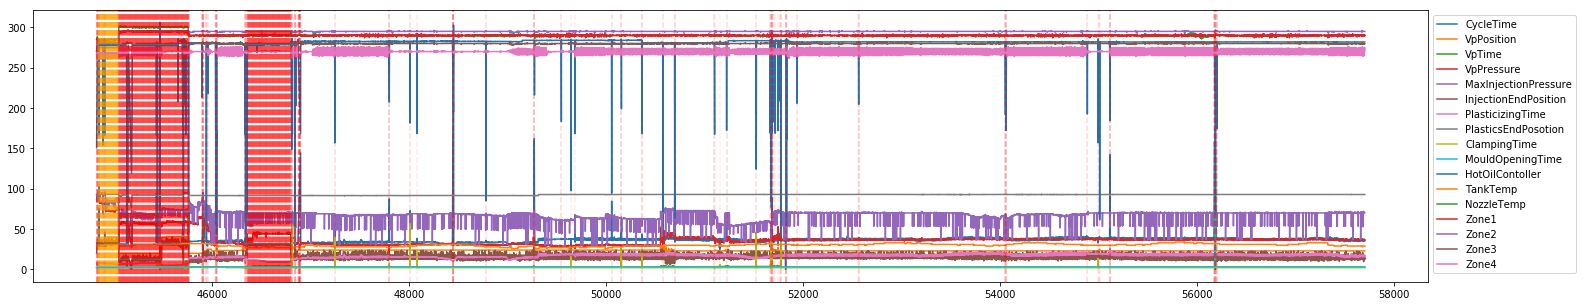

In [23]:
df[analy_col].plot(figsize=(25,5)).legend(bbox_to_anchor=(1, 1))

for xc in df[df.hmm_label==1].index.tolist():    
    plt.axvline(x=xc, color='orange', linestyle='--', alpha=0.1)
    
for xc in df[df.hmm_label==2].index.tolist():    
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.07)

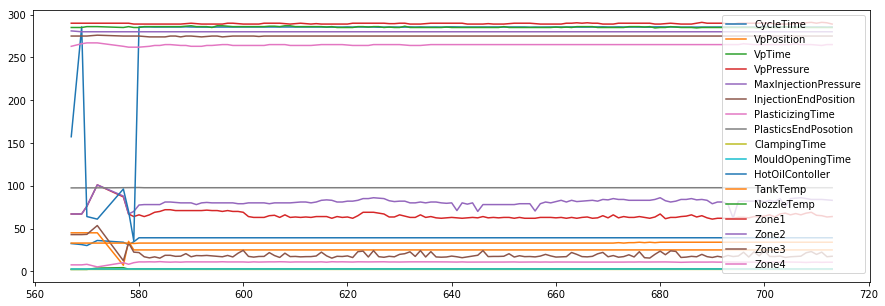

In [48]:
isee_machine[isee_machine.CycleNum==5][analy_col].plot(figsize=(15,5))

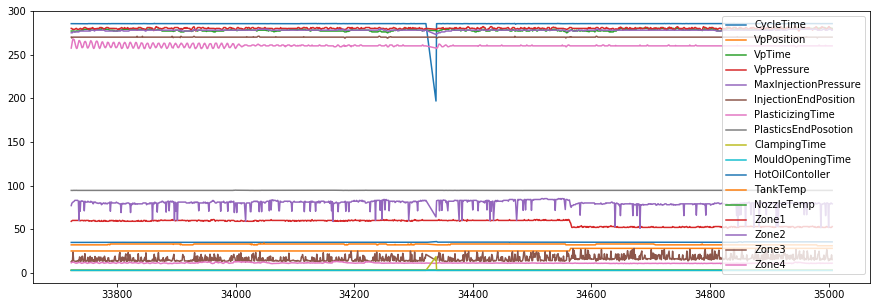

In [78]:
isee_machine[isee_machine.CycleNum==47][analy_col].plot(figsize=(15,5))

In [34]:
# 참조용
isee_machine.groupby('CycleNum').sum()['hmm_label'].sort_values(ascending=False)

CycleNum
69    7339
33    6874
9     5902
64    3978
48    3818
6     3215
11    3065
34    2650
49    2318
35    2025
13    1840
12    1536
51    1414
47    1284
8     1095
40    1074
45     996
50     966
32     874
54     856
62     489
56     436
70     375
63     354
52     348
65     329
68     307
59     291
67     285
31     279
57     271
60     261
4      255
43     248
55     224
7      218
3      158
36     156
44     155
1      153
5      147
46     145
39     137
37     130
30     126
66     126
38     112
53      99
41      88
10      69
Name: hmm_label, dtype: int32

In [ ]:
from hmmlearn.hmm import GaussianHMM
 
def fitHMM(Q, nSamples):
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=2, n_iter=1000).fit(np.reshape(Q,[len(Q),1]))
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(np.reshape(Q,[len(Q),1]))
 
    # find parameters of Gaussian HMM
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(np.reshape(Q,[len(Q),1]))
 
    # generate nSamples from Gaussian HMM
    samples = model.sample(nSamples)
 
    # re-organize mus, sigmas and P so that first row is lower mean (if not already)
    if mus[0] > mus[1]:
        mus = np.flipud(mus)
        sigmas = np.flipud(sigmas)
        P = np.fliplr(np.flipud(P))
        hidden_states = 1 - hidden_states
 
    return hidden_states, mus, sigmas, P, logProb, samples
 
# load annual flow data for the Colorado River near the Colorado/Utah state line
AnnualQ = np.loadtxt('AnnualQ.txt')
 
# log transform the data and fit the HMM
logQ = np.log(AnnualQ)
hidden_states, mus, sigmas, P, logProb, samples = fitHMM(logQ, 100)